✅ All libraries imported successfully!
📤 Please upload your 3 drone videos...


Saving cropped_Quality_Chase_footage.mp4 to cropped_Quality_Chase_footage (1).mp4
Saving Quality_Chase_footage.mp4 to Quality_Chase_footage (1).mp4
Saving videoplayback.mp4 to videoplayback (1).mp4

✅ Uploaded 3 videos: ['cropped_Quality_Chase_footage (1).mp4', 'Quality_Chase_footage (1).mp4', 'videoplayback (1).mp4']
✅ DroneTracker class defined successfully!
🔄 Loading YOLO model: yolov8x.pt
✅ Tracker initialized!

📹 Processing Video 1/3: cropped_Quality_Chase_footage (1).mp4
📹 Video Info: 1280x720 @ 29fps, 556 frames
🎬 Processing video...
   Progress:  5.4% (30/556 frames)
   Progress:  10.8% (60/556 frames)
   Progress:  16.2% (90/556 frames)
   Progress:  21.6% (120/556 frames)
   Progress:  27.0% (150/556 frames)
   Progress:  32.4% (180/556 frames)
   Progress:  37.8% (210/556 frames)
   Progress:  43.2% (240/556 frames)
   Progress:  48.6% (270/556 frames)
   Progress:  54.0% (300/556 frames)
   Progress:  59.4% (330/556 frames)
   Progress:  64.7% (360/556 frames)
   Progress: 

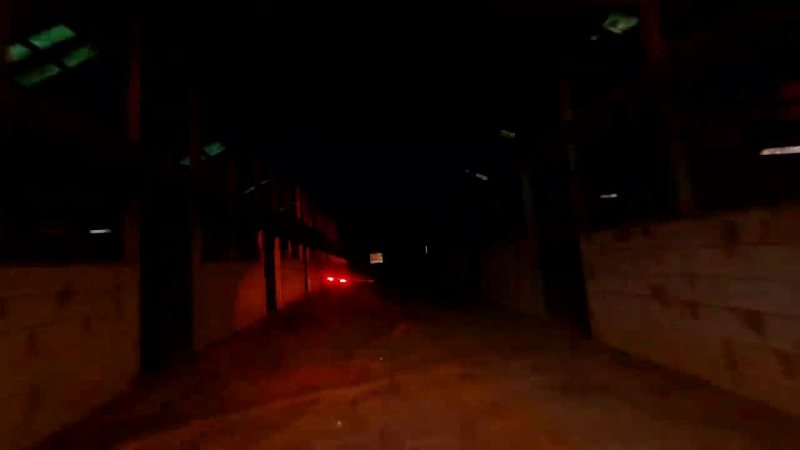



Sample from:  tracked_Quality_Chase_footage (1).mp4


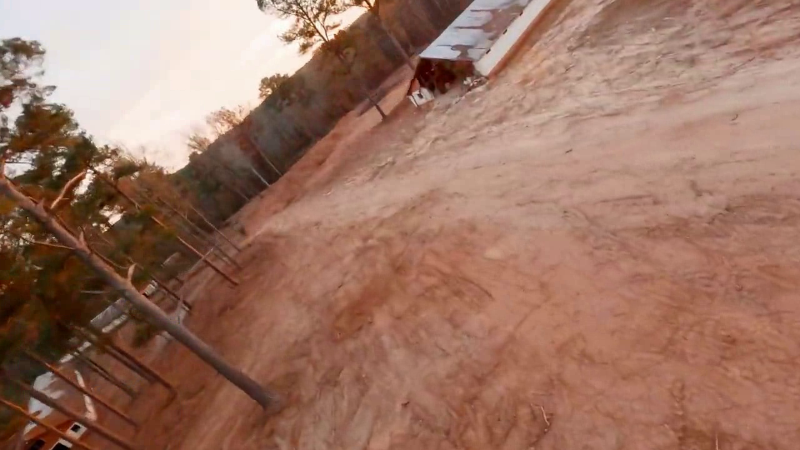



Sample from:  tracked_videoplayback (1).mp4


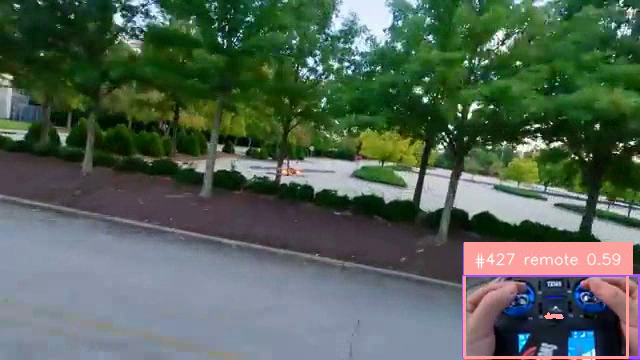



🎬 Playing first tracked video:
📥 Downloading tracked videos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded:  tracked_cropped_Quality_Chase_footage (1).mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded:  tracked_Quality_Chase_footage (1).mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded:  tracked_videoplayback (1).mp4

🎉 All done! Check your downloads folder.


In [2]:
# =============================================================================
# CELL 1: Install Dependencies
# =============================================================================
!pip install ultralytics
!pip install opencv-python-headless
!pip install supervision
!pip install lap

# =============================================================================
# CELL 2: Import Libraries
# =============================================================================
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import supervision as sv
from IPython.display import HTML
from base64 import b64encode
import os

print("✅ All libraries imported successfully!")

# =============================================================================
# CELL 3: Upload Your Videos
# =============================================================================
print("📤 Please upload your 3 drone videos...")
uploaded = files.upload()

video_files = list(uploaded.keys())
print(f"\n✅ Uploaded {len(video_files)} videos: {video_files}")

# =============================================================================
# CELL 4: Define the Drone Tracker Class
# =============================================================================
# =============================================================================
# CELL 4 (FIXED): Define the Drone Tracker Class
# =============================================================================
class DroneTracker:
    def __init__(self, model_size='yolov8x. pt'):
        """
        Initialize the drone tracker.
        model_size options:  'yolov8n.pt' (fastest), 'yolov8s.pt', 'yolov8m.pt',
                           'yolov8l.pt', 'yolov8x.pt' (most accurate)
        """
        print(f"🔄 Loading YOLO model: {model_size}")
        self.model = YOLO(model_size)

        # Initialize ByteTrack tracker
        self.tracker = sv.ByteTrack(
            track_activation_threshold=0.25,
            lost_track_buffer=30,
            minimum_matching_threshold=0.8,
            frame_rate=30
        )

        # Initialize annotators for visualization
        self.box_annotator = sv.BoxAnnotator(
            thickness=2,
        )
        self.label_annotator = sv.LabelAnnotator(
            text_thickness=1,
            text_scale=0.5,
        )
        self.trace_annotator = sv.TraceAnnotator(
            thickness=2,
            trace_length=50
        )

        print("✅ Tracker initialized!")

    def detect_and_track(self, frame, conf_threshold=0.25):
        """
        Detect and track objects in a frame.
        """
        # Run YOLO detection
        results = self. model(frame, verbose=False, conf=conf_threshold)[0]

        # Convert to supervision Detections format
        detections = sv.Detections.from_ultralytics(results)

        # Update tracker
        detections = self.tracker. update_with_detections(detections)

        return detections, results

    def annotate_frame(self, frame, detections):
        """
        Draw bounding boxes, labels, and tracking trails on the frame.
        """
        # Create labels with tracker ID and confidence
        labels = []
        for i in range(len(detections)):
            tracker_id = detections.tracker_id[i] if detections.tracker_id is not None else "N/A"
            confidence = detections. confidence[i] if detections.confidence is not None else 0
            class_id = detections.class_id[i] if detections.class_id is not None else 0
            class_name = self. model.names[class_id]
            labels.append(f"#{tracker_id} {class_name} {confidence:.2f}")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = self.trace_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.box_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.label_annotator.annotate(annotated_frame, detections, labels)

        return annotated_frame

    def process_video(self, input_path, output_path, conf_threshold=0.25,
                      target_classes=None, show_progress=True):
        """
        Process entire video and save result.
        """
        # Open video
        cap = cv2.VideoCapture(input_path)

        if not cap.isOpened():
            print(f"❌ Error: Cannot open video {input_path}")
            return

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap. get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap. get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"📹 Video Info: {width}x{height} @ {fps}fps, {total_frames} frames")

        # Initialize video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Reset tracker for new video
        self. tracker = sv.ByteTrack(
            track_activation_threshold=0.25,
            lost_track_buffer=30,
            minimum_matching_threshold=0.8,
            frame_rate=fps
        )

        frame_count = 0

        print("🎬 Processing video...")

        while True:
            ret, frame = cap. read()
            if not ret:
                break

            # Detect and track
            detections, results = self.detect_and_track(frame, conf_threshold)

            # Filter by target classes if specified
            if target_classes is not None and len(detections) > 0:
                class_names = [self.model.names[cid] for cid in detections.class_id]
                mask = [name in target_classes for name in class_names]
                detections = detections[mask]

            # Annotate frame
            annotated_frame = self.annotate_frame(frame, detections)

            # Write frame
            out. write(annotated_frame)

            frame_count += 1
            if show_progress and frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"   Progress:  {progress:.1f}% ({frame_count}/{total_frames} frames)")  # FIXED: removed space

        # Release resources
        cap.release()
        out.release()

        print(f"✅ Video saved to: {output_path}")
        return output_path

print("✅ DroneTracker class defined successfully!")

# =============================================================================
# CELL 5: Initialize the Tracker
# =============================================================================
# Choose model size based on your needs:
# - 'yolov8n.pt':  Fastest, less accurate
# - 'yolov8s.pt': Good balance
# - 'yolov8m.pt': Better accuracy
# - 'yolov8l.pt': High accuracy
# - 'yolov8x. pt': Best accuracy, slowest

tracker = DroneTracker(model_size='yolov8x.pt')

# =============================================================================
# CELL 6: Process All Videos
# =============================================================================
output_files = []

for i, video_file in enumerate(video_files):
    print(f"\n{'='*50}")
    print(f"📹 Processing Video {i+1}/{len(video_files)}: {video_file}")
    print('='*50)

    output_name = f"tracked_{video_file}"

    # Process video - tracking all objects
    # For drones, try these target_classes if you want to filter:
    # target_classes=['airplane', 'bird', 'kite'] or None for all

    tracker.process_video(
        input_path=video_file,
        output_path=output_name,
        conf_threshold=0.25,  # Lower = more detections, might have false positives
        target_classes=None,  # Set to None to detect everything
        show_progress=True
    )

    output_files.append(output_name)

print(f"\n🎉 All videos processed! Output files: {output_files}")

# =============================================================================
# CELL 7: Display a Sample Frame from Each Output Video
# =============================================================================
print("\n📸 Sample frames from tracked videos:\n")

for output_file in output_files:
    cap = cv2.VideoCapture(output_file)
    # Skip to middle of video for a good sample
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
    ret, frame = cap. read()
    cap.release()

    if ret:
        print(f"Sample from:  {output_file}")
        # Resize for display if too large
        if frame.shape[1] > 800:
            scale = 800 / frame.shape[1]
            frame = cv2.resize(frame, None, fx=scale, fy=scale)
        cv2_imshow(frame)
        print("\n")

# =============================================================================
# CELL 8: Play Video in Notebook (Optional)
# =============================================================================
def play_video_in_notebook(video_path):
    """Display video directly in the notebook."""
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width=800 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """)

# Display first tracked video
if output_files:
    print("🎬 Playing first tracked video:")
    play_video_in_notebook(output_files[0])

# =============================================================================
# CELL 9: Download All Tracked Videos
# =============================================================================
print("📥 Downloading tracked videos...")

for output_file in output_files:
    if os.path.exists(output_file):
        files. download(output_file)
        print(f"   ✅ Downloaded:  {output_file}")

print("\n🎉 All done! Check your downloads folder.")

# =============================================================================
# CELL 10:  ADVANCED - Train Custom Drone Detector (Optional)
# =============================================================================
# If the pre-trained model doesn't detect drones well, you can fine-tune it!
# This requires labeled drone images.

"""
# Uncomment and run this cell if you want to train a custom model

from ultralytics import YOLO

# Load a pre-trained model
model = YOLO('yolov8x.pt')

# Train on custom drone dataset
# You need to prepare a dataset in YOLO format first
# See: https://docs.ultralytics.com/datasets/detect/

results = model. train(
    data='path/to/your/drone_dataset.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='drone_detector'
)

# Use your custom model
custom_tracker = DroneTracker(model_size='runs/detect/drone_detector/weights/best.pt')
"""

# =============================================================================
# CELL 11: ALTERNATIVE - Manual ROI Tracking (If YOLO doesn't detect drone)
# =============================================================================
def track_with_manual_roi(video_path, output_path):
    """
    If automatic detection fails, use this for manual ROI selection
    with OpenCV's built-in trackers.
    """
    # Note: This won't work directly in Colab due to GUI limitations
    # But you can use it locally

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap. read()

    if not ret:
        print("Cannot read video")
        return

    # For Colab, we'll use a simple approach with predefined ROI
    # In local environment, you could use cv2.selectROI()

    # Initialize tracker (CSRT is good for accuracy)
    tracker = cv2.TrackerCSRT_create()

    # You would manually set the initial bounding box here
    # bbox = (x, y, width, height)
    # For demo, let's use center of frame
    h, w = frame. shape[:2]
    bbox = (w//2 - 50, h//2 - 50, 100, 100)  # Example initial box

    tracker.init(frame, bbox)

    fps = int(cap. get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap. read()
        if not ret:
            break

        success, bbox = tracker. update(frame)

        if success:
            x, y, w, h = [int(v) for v in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Drone Tracked", (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        else:
            cv2.putText(frame, "Lost Track!", (50, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ Manual tracking complete:  {output_path}")

# Uncomment to use manual tracking:
# track_with_manual_roi(video_files[0], "manual_tracked. mp4")

In [3]:
# =============================================================================
# CELL 1: Install Dependencies (run if not already installed)
# =============================================================================
!pip install ultralytics opencv-python-headless supervision lap --quiet
print("✅ Dependencies installed!")

✅ Dependencies installed!


In [4]:
# =============================================================================
# CELL 2: Import Libraries
# =============================================================================
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
from collections import defaultdict
from IPython.display import HTML
from base64 import b64encode
import os

print("✅ All libraries imported!")

✅ All libraries imported!


In [5]:
# =============================================================================
# CELL 3: Upload Videos
# =============================================================================
print("📤 Upload your drone videos...")
uploaded = files.upload()
video_files = list(uploaded.keys())
print(f"✅ Uploaded:  {video_files}")

📤 Upload your drone videos...


Saving cropped_Quality_Chase_footage.mp4 to cropped_Quality_Chase_footage (2).mp4
Saving Quality_Chase_footage.mp4 to Quality_Chase_footage (2).mp4
Saving videoplayback.mp4 to videoplayback (2).mp4
✅ Uploaded:  ['cropped_Quality_Chase_footage (2).mp4', 'Quality_Chase_footage (2).mp4', 'videoplayback (2).mp4']


In [8]:
# =============================================================================
# CELL 4: FIXED - Improved Drone Tracker with PROPER TRACKING & TRAILS
# =============================================================================

class ImprovedDroneTracker:
    def __init__(self):
        """Initialize with YOLOv8 + ByteTrack for robust tracking."""
        print("🔄 Loading YOLOv8x model...")
        self.model = YOLO('yolov8x.pt')

        # Store track history for drawing trails
        self. track_history = defaultdict(lambda: [])

        # Define colors for different track IDs
        self. colors = [
            (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
            (255, 0, 255), (0, 255, 255), (128, 0, 255), (255, 128, 0)
        ]

        print("✅ Tracker ready!")

    def get_color(self, track_id):
        """Get consistent color for a track ID."""
        return self.colors[track_id % len(self.colors)]

    def filter_drone_detections(self, boxes, frame_shape):
        """
        Smart filtering to identify the most likely drone.
        """
        if len(boxes) == 0:
            return []

        frame_h, frame_w = frame_shape[: 2]
        frame_area = frame_h * frame_w

        filtered_indices = []

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box[: 4]
            box_w = x2 - x1
            box_h = y2 - y1
            box_area = box_w * box_h

            # Calculate relative size
            relative_size = box_area / frame_area

            # Filter criteria for drone-like objects
            aspect_ratio = box_w / max(box_h, 1)

            if 0.0005 < relative_size < 0.3 and 0.2 < aspect_ratio < 5:
                filtered_indices.append(i)

        return filtered_indices

    def process_video(self, input_path, output_path, conf_threshold=0.15):
        """
        Process video with PROPER tracking and trail visualization.
        """
        cap = cv2.VideoCapture(input_path)

        if not cap.isOpened():
            print(f"❌ Cannot open:  {input_path}")
            return None

        # Video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap. get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap. get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"📹 Video: {width}x{height} @ {fps}fps, {total_frames} frames")

        # Output video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Clear track history for new video
        self.track_history. clear()

        frame_count = 0
        print("🎬 Processing with tracking...")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run YOLOv8 tracking - FIXED: removed space in bytetrack.yaml
            results = self. model. track(
                frame,
                persist=True,
                conf=conf_threshold,
                iou=0.5,
                tracker="bytetrack.yaml",  # FIXED: no space!
                verbose=False
            )

            # Get the annotated frame
            annotated_frame = frame.copy()

            if results[0].boxes is not None and len(results[0].boxes) > 0:
                boxes = results[0]. boxes. xyxy. cpu().numpy()

                # Check if tracking IDs exist
                if results[0].boxes.id is not None:
                    track_ids = results[0]. boxes.id.int().cpu().numpy()
                    classes = results[0]. boxes.cls.int().cpu().numpy()
                    confs = results[0].boxes.conf. cpu().numpy()

                    # Filter for drone-like objects
                    valid_indices = self. filter_drone_detections(boxes, frame.shape)

                    for i in valid_indices:
                        x1, y1, x2, y2 = boxes[i]. astype(int)
                        track_id = track_ids[i]
                        class_id = classes[i]
                        conf = confs[i]

                        # Get center point for trail
                        center_x = int((x1 + x2) / 2)
                        center_y = int((y1 + y2) / 2)

                        # Add to track history
                        self.track_history[track_id].append((center_x, center_y))

                        # Keep only last 60 points for trail
                        if len(self. track_history[track_id]) > 60:
                            self.track_history[track_id] = self.track_history[track_id][-60:]

                        # Get color for this track
                        color = self.get_color(track_id)

                        # Draw bounding box (thick)
                        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 3)

                        # Draw tracking trail
                        points = self.track_history[track_id]
                        if len(points) > 1:
                            for j in range(1, len(points)):
                                thickness = int(np.sqrt(64 / float(len(points) - j + 1)) * 2)
                                thickness = max(1, min(thickness, 5))
                                cv2.line(annotated_frame, points[j-1], points[j], color, thickness)

                        # Draw center point
                        cv2.circle(annotated_frame, (center_x, center_y), 6, color, -1)
                        cv2.circle(annotated_frame, (center_x, center_y), 8, (255, 255, 255), 2)

                        # Label
                        label = f"DRONE #{track_id} ({conf:.0%})"

                        # Label background
                        (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                        cv2.rectangle(annotated_frame, (x1, y1 - 30), (x1 + label_w + 10, y1), color, -1)
                        cv2.putText(annotated_frame, label, (x1 + 5, y1 - 8),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Add frame info
            cv2.putText(annotated_frame, f"Frame: {frame_count}/{total_frames}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(annotated_frame, f"Tracking: {len(self.track_history)} objects", (10, 60),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            out.write(annotated_frame)
            frame_count += 1

            # Progress update
            if frame_count % 50 == 0:
                pct = (frame_count / total_frames) * 100
                print(f"   Progress: {pct:.1f}%")

        cap.release()
        out.release()

        print(f"✅ Saved: {output_path}")
        print(f"   Total unique tracks: {len(self.track_history)}")

        return output_path

print("✅ ImprovedDroneTracker class defined!")

✅ ImprovedDroneTracker class defined!


In [9]:
# =============================================================================
# CELL 5: Process All Videos with Improved Tracker
# =============================================================================

# Initialize tracker
tracker = ImprovedDroneTracker()

# Process each video
output_files = []

for i, video_file in enumerate(video_files):
    print(f"\n{'='*60}")
    print(f"📹 Processing Video {i+1}/{len(video_files)}: {video_file}")
    print('='*60)

    output_name = f"tracked_{video_file}"

    result = tracker.process_video(
        input_path=video_file,
        output_path=output_name,
        conf_threshold=0.15  # Lower threshold to catch more detections
    )

    if result:
        output_files.append(output_name)

print(f"\n🎉 Done! Processed {len(output_files)} videos")

🔄 Loading YOLOv8x model...
✅ Tracker ready!

📹 Processing Video 1/3: cropped_Quality_Chase_footage (2).mp4
📹 Video: 1280x720 @ 29fps, 556 frames
🎬 Processing with tracking...
   Progress: 9.0%
   Progress: 18.0%
   Progress: 27.0%
   Progress: 36.0%
   Progress: 45.0%
   Progress: 54.0%
   Progress: 62.9%
   Progress: 71.9%
   Progress: 80.9%
   Progress: 89.9%
   Progress: 98.9%
✅ Saved: tracked_cropped_Quality_Chase_footage (2).mp4
   Total unique tracks: 8

📹 Processing Video 2/3: Quality_Chase_footage (2).mp4
📹 Video: 1280x720 @ 29fps, 4402 frames
🎬 Processing with tracking...
   Progress: 1.1%
   Progress: 2.3%
   Progress: 3.4%
   Progress: 4.5%
   Progress: 5.7%
   Progress: 6.8%
   Progress: 8.0%
   Progress: 9.1%
   Progress: 10.2%
   Progress: 11.4%
   Progress: 12.5%
   Progress: 13.6%
   Progress: 14.8%
   Progress: 15.9%
   Progress: 17.0%
   Progress: 18.2%
   Progress: 19.3%
   Progress: 20.4%
   Progress: 21.6%
   Progress: 22.7%
   Progress: 23.9%
   Progress: 25.0%
  

📸 Sample frames from tracked videos:

📹 tracked_cropped_Quality_Chase_footage (2).mp4


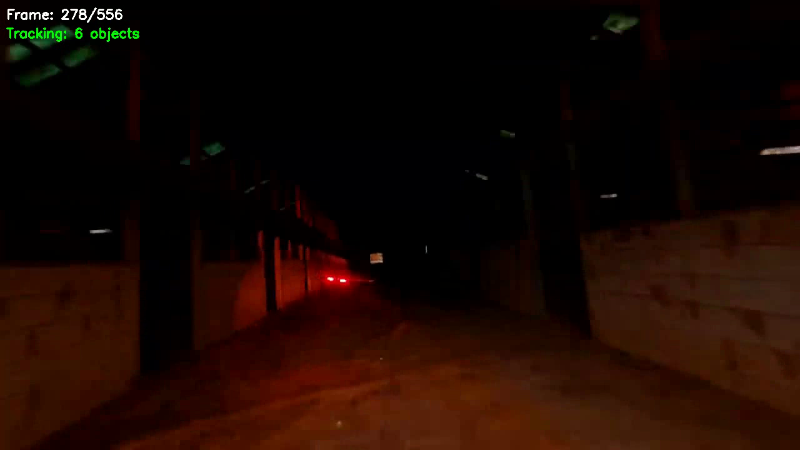


📹 tracked_Quality_Chase_footage (2).mp4


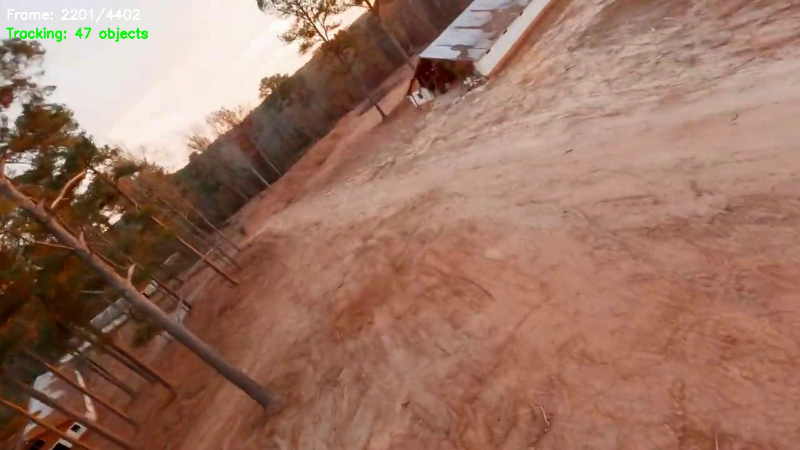


📹 tracked_videoplayback (2).mp4


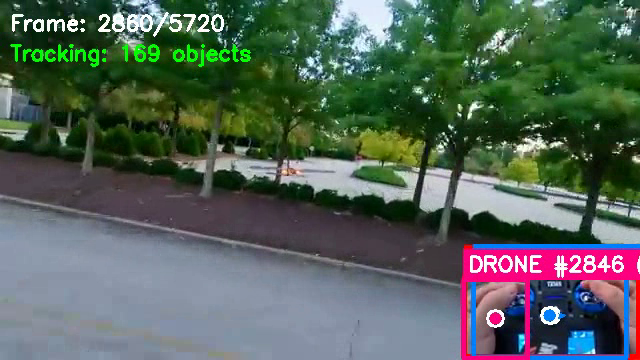

In [10]:
# =============================================================================
# CELL 6: Preview Sample Frames
# =============================================================================

print("📸 Sample frames from tracked videos:\n")

for output_file in output_files:
    if os.path.exists(output_file):
        cap = cv2.VideoCapture(output_file)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Get frame from middle of video
        cap.set(cv2.CAP_PROP_POS_FRAMES, total // 2)
        ret, frame = cap. read()
        cap.release()

        if ret:
            print(f"📹 {output_file}")
            if frame. shape[1] > 800:
                scale = 800 / frame.shape[1]
                frame = cv2.resize(frame, None, fx=scale, fy=scale)
            cv2_imshow(frame)
            print()

In [11]:
# =============================================================================
# CELL 7: Download Results
# =============================================================================

print("📥 Downloading tracked videos...\n")

for output_file in output_files:
    if os. path.exists(output_file):
        files. download(output_file)
        print(f"✅ Downloaded: {output_file}")

print("\n🎉 All done! Check your downloads.")

📥 Downloading tracked videos...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: tracked_cropped_Quality_Chase_footage (2).mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: tracked_Quality_Chase_footage (2).mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: tracked_videoplayback (2).mp4

🎉 All done! Check your downloads.
